In [17]:
#https://web.tuat.ac.jp/~yamanaka/pcoms2019/Cahn-Hilliard-2d.html

import math
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt

In [18]:
nx = 101 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
ofst = nx - 1

dx, dy = 2.0e-9, 2.0e-9 # spacing of computational grids [m]
c0 = 0.5325 # average composition of B atom [atomic fraction]
R = 8.314 # gas constant
temp = 673 # temperature [K]
nsteps = 15000# total number of time-steps

RxT = R*temp

dx_sq = dx*dx
dy_sq = dy*dy

check_range = 9

dist_base = 5.5

dist_check_square = dist_base**2

dist_check_max = (dist_base + 2)**2

beta = 0.021 # for probability of accept / reject

c_max = 1.0

# variables for force of repulsion between active particles
colloid_diameter = 5

coll_diam_6 = colloid_diameter**6

calc_forces = True
force_length_scale = colloid_diameter * 2**(1/6)
interaction_range = 6

# same initial conditions for all trials
c_ini = c0 + np.random.rand(nx, ny)*0.01 - np.random.rand(nx, ny)*0.01

f_scale = 40/5*dt_inc

In [19]:
La = 21000.-9.*temp # Atom intaraction constant [J/mol]
ac = 3.0e-14 # gradient coefficient [Jm2/mol]
Da = 1.0e-04*np.exp(-30000.0/R/temp) # diffusion coefficient of A atom [m2/s]
Db = 2.0e-05*np.exp(-30000.0/R/temp) # diffusion coefficient of B atom [m2/s]
c = np.zeros((nx, ny))

D_R_T = Da/R/temp
DbDa = Db/Da

dt_inc = 0.1

dt = (dx*dx/Da)*dt_inc # time increment [s]

gamma = 0.88

force_mul = (2 * 1/5 * dt_inc)**0.5

bc_list_j = [0,1,ny-2, ny-1]
bc_list_i = [0,1,nx-2, nx-1]

In [20]:
check_ring_cos = []
check_ring_sin = []

scale_factor = 1.1

for j in range(0,32):
    check_ring_cos.append(colloid_diameter/2*np.cos(j/32.0*2*np.pi))
    check_ring_sin.append(colloid_diameter/2*np.sin(j/32.0*2*np.pi))

ring_check = np.zeros((7,7))

In [21]:
def update_orderparameter(c,c_new, center_x,  center_y):
    
    # build matrix for setting multiplier on La
    k_mul = np.ones((nx,ny)) * 0.5
    
    for z in range(len(center_x)):
   
        i_base = round(center_x[z])
        j_base = round(center_y[z])

        for j in range(j_base - check_range, j_base + check_range):
            for i in range(i_base - check_range, i_base + check_range):

                j_use = j
                i_use = i

                if (j_use >= ny):
                    j_use -= ny

                if (i_use >= nx):
                    i_use -= nx

                if (j_use < 0):
                    j_use += ny

                if (i_use < 0):
                    i_use += nx

                dist_sq = (i - center_x[z])**2 + (j - center_y[z])**2

                k_mul_prop = 0.5

                if ((dist_sq > dist_check_square) and (dist_sq < dist_check_max)):
                    k_mul_prop = 0.9 - 0.4 * (dist_sq**0.5-dist_base)/2
                elif dist_sq >= dist_check_max:
                    k_mul_prop = 0.5
                elif dist_sq <= dist_check_square:
                    k_mul_prop = 0.9

                # keep highest value
                if (k_mul_prop > k_mul[i_use,j_use]):
                     k_mul[i_use,j_use] = k_mul_prop

    # update concentrations
    
    # chemical term of the diffusion potential
    mu_chem_c[:,:] = RxT*(np.log(c[:,:])-np.log(c_max-c[:,:])) + k_mul[:,:]*La*(c_max-2.0*c[:,:])
        
    mu_chem_w[1:,:] = RxT*(np.log(c[0:-1,:])-np.log(c_max-c[0:-1,:])) + k_mul[0:-1,:]*La*(c_max-2.0*c[0:-1,:]) 
    mu_chem_w[0,:] = RxT*(np.log(c[-1,:])-np.log(c_max-c[-1,:])) + k_mul[-1,:]*La*(c_max-2.0*c[-1,:])
    
    mu_chem_e[0:-1,:] = RxT*(np.log(c[1:,:])-np.log(c_max-c[1:,:])) + k_mul[1:,:]*La*(c_max-2.0*c[1:,:])
    mu_chem_e[-1,:] = RxT*(np.log(c[0,:])-np.log(c_max-c[0,:])) + k_mul[0,:]*La*(c_max-2.0*c[0,:])
    
    mu_chem_n[:,0:-1] = RxT*(np.log(c[:,1:])-np.log(c_max-c[:,1:])) + k_mul[:,1:]*La*(c_max-2.0*c[:,1:]) 
    mu_chem_n[:,-1] = RxT*(np.log(c[:,0])-np.log(c_max-c[:,0])) + k_mul[:,0]*La*(c_max-2.0*c[:,0])
    
    mu_chem_s[:,1:] = RxT*(np.log(c[:,0:-1])-np.log(c_max-c[:,0:-1])) + k_mul[:,0:-1]*La*(c_max-2.0*c[:,0:-1])
    mu_chem_s[:,0] = RxT*(np.log(c[:,-1])-np.log(c_max-c[:,-1])) + k_mul[:,-1]*La*(c_max-2.0*c[:,-1])
    
    # gradient term of the diffusion potential
    mu_grad_c[2:-2,2:-2] = -ac*( (c[3:-1,2:-2] -2.0*c[2:-2,2:-2] +c[1:-3,2:-2] )/dx_sq + 
                                 (c[2:-2,3:-1] -2.0*c[2:-2,2:-2] +c[2:-2,1:-3] )/dy_sq )
    mu_grad_w[2:-2,2:-2] = -ac*( (c[2:-2,2:-2] -2.0*c[1:-3,2:-2] +c[0:-4,2:-2] )/dx_sq + 
                                 (c[1:-3,3:-1] -2.0*c[1:-3,2:-2] +c[1:-3,1:-3] )/dy_sq )
    mu_grad_e[2:-2,2:-2] = -ac*( (c[4:,2:-2]   -2.0*c[3:-1,2:-2] +c[2:-2,2:-2] )/dx_sq + 
                                 (c[3:-1,3:-1] -2.0*c[3:-1,2:-2] +c[3:-1,1:-3] )/dy_sq )  
    mu_grad_n[2:-2,2:-2] = -ac*( (c[3:-1,3:-1] -2.0*c[2:-2,3:-1] +c[1:-3,3:-1] )/dx_sq + 
                                 (c[2:-2,4:]   -2.0*c[2:-2,3:-1] +c[2:-2,2:-2] )/dy_sq ) 
    mu_grad_s[2:-2,2:-2] = -ac*( (c[3:-1,1:-3] -2.0*c[2:-2,1:-3] +c[1:-3,1:-3] )/dx_sq + 
                                 (c[2:-2,2:-2] -2.0*c[2:-2,1:-3] +c[2:-2,0:-4] )/dy_sq )
    
    # fill in boundary conditions on gradient matrix
    for j in bc_list_j:
        for i in range(0,nx):
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_grad_c[i,j] = -ac*( (ce -2.0*cc +cw )/dx_sq + (cn  -2.0*cc +cs )/dy_sq )
            mu_grad_w[i,j] = -ac*( (cc -2.0*cw +cww)/dx_sq + (cnw -2.0*cw +csw)/dy_sq )
            mu_grad_e[i,j] = -ac*( (cee-2.0*ce +cc )/dx_sq + (cne -2.0*ce +cse)/dy_sq )  
            mu_grad_n[i,j] = -ac*( (cne-2.0*cn +cnw)/dx_sq + (cnn -2.0*cn +cc )/dy_sq ) 
            mu_grad_s[i,j] = -ac*( (cse-2.0*cs +csw)/dx_sq + (cc  -2.0*cs +css)/dy_sq ) 
            
    for j in range(2,ny-2):
        for i in bc_list_i:
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_grad_c[i,j] = -ac*( (ce -2.0*cc +cw )/dx_sq + (cn  -2.0*cc +cs )/dy_sq )
            mu_grad_w[i,j] = -ac*( (cc -2.0*cw +cww)/dx_sq + (cnw -2.0*cw +csw)/dy_sq )
            mu_grad_e[i,j] = -ac*( (cee-2.0*ce +cc )/dx_sq + (cne -2.0*ce +cse)/dy_sq )  
            mu_grad_n[i,j] = -ac*( (cne-2.0*cn +cnw)/dx_sq + (cnn -2.0*cn +cc )/dy_sq ) 
            mu_grad_s[i,j] = -ac*( (cse-2.0*cs +csw)/dx_sq + (cc  -2.0*cs +css)/dy_sq ) 

            
    # add potentials            
    mu_c[:,:] = mu_chem_c[:,:] + mu_grad_c[:,:]
    mu_w[:,:] = mu_chem_w[:,:] + mu_grad_w[:,:]
    mu_e[:,:] = mu_chem_e[:,:] + mu_grad_e[:,:]
    mu_n[:,:] = mu_chem_n[:,:] + mu_grad_n[:,:] 
    mu_s[:,:] = mu_chem_s[:,:] + mu_grad_s[:,:] 
    
       
    nabla_mu[:,:] = (mu_w[:,:] -2.0*mu_c[:,:] + mu_e[:,:])/dx_sq + (mu_n[:,:] -2.0*mu_c[:,:] + mu_s[:,:])/dy_sq    
    
    dc2dx2[1:-1,:] = ((c[2:,:]-c[0:-2,:])*(mu_e[1:-1,:]-mu_w[1:-1,:]))/(4.0*dx_sq)    
    dc2dx2[0,:] = ((c[1,:]-c[-1,:])*(mu_e[0,:]-mu_w[0,:]))/(4.0*dx_sq)
    dc2dx2[-1,:] = ((c[0,:]-c[-2,:])*(mu_e[-1,:]-mu_w[-1,:]))/(4.0*dx_sq)
        
    dc2dy2[:,1:-1] = ((c[:,2:]-c[:,0:-2])*(mu_n[:,1:-1]-mu_s[:,1:-1]))/(4.0*dy_sq)
    dc2dy2[:,0] = ((c[:,-1]-c[:,1])*(mu_n[:,0]-mu_s[:,0]))/(4.0*dy_sq)
    dc2dy2[:,-1] = ((c[:,-2]-c[:,0])*(mu_n[:,-1]-mu_s[:,-1]))/(4.0*dy_sq)

    mob[:,:] = (D_R_T)*(c[:,:]+DbDa*(1.0-c[:,:]))*c[:,:]*(1.0-c[:,:]) 
    dmdc[:,:] = (D_R_T)*((1.0-DbDa)*c[:,:]*(1.0-c[:,:])+(c[:,:]+DbDa*(1.0-c[:,:]))*(1.0-2.0*c[:,:])) 

    dcdt[:,:] = mob[:,:]*nabla_mu[:,:] + dmdc[:,:]*(dc2dx2[:,:] + dc2dy2[:,:]) # right-hand side of Cahn-Hilliard equation
    c_new[:,:] = c[:,:] + dcdt[:,:] *dt # update order parameter c 

In [22]:
def force_calc(i_index, j_index, x_offset, y_offset):
    
    d_vector_x = c_x[j_index] - (c_x[i_index] - x_offset)
    d_vector_y = c_y[j_index] - (c_y[i_index] - y_offset)
    dist_f = (d_vector_x**2 + d_vector_y**2)**0.5

    f_mag = 0
    if (dist_f < force_length_scale):
        if (dist_f >= colloid_diameter*1.06):
            f_mag = f_scale*(coll_diam_6 * 6/dist_f**7*(1-coll_diam_6*2/dist_f**6))
        else:
            f_mag = 0.26205954*dist_f*(dist_f-5.48841692)
        
        forces_x[i_index] += f_mag * d_vector_x/dist_f
        forces_y[i_index] += f_mag * d_vector_y/dist_f

        forces_x[j_index] += -f_mag * d_vector_x/dist_f
        forces_y[j_index] += -f_mag * d_vector_y/dist_f

        def_move[i_index] = 1
        def_move[j_index] = 1

In [23]:
def Determine_Proper_Seperation_2D(Particle_X, Particle_Y, Test_X, Test_Y, Min_Distance):

    Diff_X = Particle_X - Test_X
    Diff_Y = Particle_Y - Test_Y

    Temp_Dist = (pow((Diff_X), 2) + pow((Diff_Y), 2))**0.5

    if (Temp_Dist < Min_Distance):
        return False

    return True
    
X_Offsets_2D = [0, ofst, -ofst, 0, 0, ofst, ofst, -ofst, -ofst]
Y_Offsets_2D = [0, 0, 0, ofst, -ofst, ofst, -ofst, ofst, -ofst]

def Fill_Ring_Check(x_test_r, y_test_r):

    for r in range(0,32):
        x_r = x_test_r + check_ring_cos[r]
        y_r = y_test_r + check_ring_sin[r]

        x_f = math.floor(x_r) - math.floor(x_test_r)
        y_f = math.floor(y_r) - math.floor(y_test_r)

        ring_check[int(x_f+3),int(y_f+3)] = 1

In [24]:
x_diffs_all = []
y_diffs_all = []

x_cent_all = []
y_cent_all = []

Num_Colloids = 128

for it_1 in range(0,1):
    
    # clear matrices    
    c[:,:] = c_ini[:,:]
    c_new = np.zeros((nx,ny)) # order parameter c at time t+dt

    mu_chem_c = np.zeros((nx,ny))
    mu_chem_w = np.zeros((nx,ny))
    mu_chem_e = np.zeros((nx,ny))
    mu_chem_n = np.zeros((nx,ny))
    mu_chem_s = np.zeros((nx,ny))

    mu_grad_c = np.zeros((nx,ny))
    mu_grad_w = np.zeros((nx,ny))
    mu_grad_e = np.zeros((nx,ny))
    mu_grad_n = np.zeros((nx,ny))
    mu_grad_s = np.zeros((nx,ny))

    mu_c = np.zeros((nx,ny))
    mu_w = np.zeros((nx,ny))
    mu_e = np.zeros((nx,ny))
    mu_n = np.zeros((nx,ny))
    mu_s = np.zeros((nx,ny))

    nabla_mu = np.zeros((nx,ny))

    dc2dx2 = np.zeros((nx,ny))
    dc2dy2 = np.zeros((nx,ny))

    mob = np.zeros((nx,ny))
    dmdc = np.zeros((nx,ny))
    dcdt = np.zeros((nx,ny))
    
    c_x = []
    c_y = []
    
    x_centers = []
    y_centers = []
    
    x_diffs = []
    y_diffs = []
    
    x_diffs_save = []
    y_diffs_save = []
    
    for i in range(0,Num_Colloids):
        
        Good_Position = False;

        while (not Good_Position):
            Temp_X = np.random.rand()*ofst
            Temp_Y = np.random.rand()*ofst

            Good_Position = True

            for j in range(0,i):
                Current_X = c_x[j]
                Current_Y = c_y[j]

                for k in range(0,9):
                    Good_Position &= Determine_Proper_Seperation_2D(Current_X, Current_Y,
                                    (Temp_X + X_Offsets_2D[k]), (Temp_Y + Y_Offsets_2D[k]), interaction_range)
        
        c_x.append(Temp_X);
        c_y.append(Temp_Y);

        x_centers.append([Temp_X])
        y_centers.append([Temp_Y])

        x_diffs.append([0])
        y_diffs.append([0])
        
        x_diffs_save.append([0])
        y_diffs_save.append([0])

#     c_x = [30, 40, 30, 40]
#     c_y = [30, 40, 40, 30]

#     x_centers = [[30],[40],[30],[40]]
#     y_centers = [[30],[40],[40],[30]]
    
#     x_diffs = [[0],[0],[0],[0]]
#     y_diffs = [[0],[0],[0],[0]]
    
#     c_x = [10, 35, 60, 20, 50, 10, 35, 60]
#     c_y = [10, 10, 10, 35, 35, 60, 60, 60]

#     x_centers = [[10], [35], [60], [20], [50], [10], [35], [60]]
#     y_centers = [[10], [10], [10], [35], [35], [60], [60], [60]]
    
#     x_diffs = [[0],[0],[0],[0],[0],[0],[0],[0]]
#     y_diffs = [[0],[0],[0],[0],[0],[0],[0],[0]]

#     c_x = [35, 35]
#     c_y = [30, 40]

#     x_centers = [[35],[35]]
#     y_centers = [[30],[40]]
    
#     x_diffs = [[0],[0]]
#     y_diffs = [[0],[0]]

    
    
    for nstep in range(1,nsteps+1):
        update_orderparameter(c,c_new, c_x, c_y)
        c[:,:] = c_new[:,:] # swap c at time t and c at time t+dt
        
        forces_x = [0] * len(c_x)
        forces_y = [0] * len(c_x)
        
        def_move = [0] * len(c_x)
    
        Corner_list_LU = []
        Corner_list_RU = []
        Corner_list_LD = []
        Corner_list_RD = []

        Edge_list_L = []
        Edge_list_R = []
        Edge_list_U = []
        Edge_list_D = []
        
        if calc_forces == True:
            for i in range(0, len(c_x)):
               
                if (c_x[i] < interaction_range):

                    if (c_y[i] < interaction_range):
                        Corner_list_LD.append(i)

                    elif (c_y[i] > (ofst - interaction_range)):
                        Corner_list_LU.append(i)

                    else:
                        Edge_list_L.append(i)

                elif (c_x[i] > (ofst - interaction_range)):

                    if (c_y[i] < interaction_range):
                        Corner_list_RD.append(i)

                    elif (c_y[i] > (ofst - interaction_range)):
                        Corner_list_RU.append(i)

                    else:
                        Edge_list_R.append(i)

                elif (c_y[i] < interaction_range):
                    Edge_list_D.append(i)

                elif (c_y[i] > (ofst - interaction_range)):
                    Edge_list_U.append(i)
        
            for i in range(0, len(c_x)-1):
                for j in range(i+1, len(c_x)):               
                    force_calc(i, j, 0, 0)

            for i in range(0, len(Edge_list_R)):
                for j in range(0, len(Edge_list_L)):             
                    force_calc(Edge_list_R[i], Edge_list_L[j], ofst, 0)

            for i in range(0, len(Edge_list_U)):
                for j in range(0, len(Edge_list_D)):             
                    force_calc(Edge_list_U[i], Edge_list_D[j], 0, ofst)

            for i in range(0, len(Corner_list_RU)):
                for j in range(0, len(Corner_list_LD)):             
                    force_calc(Corner_list_RU[i], Corner_list_LD[j], ofst, ofst)

            for i in range(0, len(Corner_list_LU)):
                for j in range(0, len(Corner_list_RD)):             
                    force_calc(Corner_list_LU[i], Corner_list_RD[j], -ofst, ofst)
                    
            for i in range(0, len(Corner_list_RU)):
                for j in range(0, len(Corner_list_RD)):             
                    force_calc(Corner_list_RU[i], Corner_list_RD[j], 0, ofst)

            for i in range(0, len(Corner_list_LU)):
                for j in range(0, len(Corner_list_LD)):             
                    force_calc(Corner_list_LU[i], Corner_list_LD[j], 0, ofst)

            for i in range(0, len(Corner_list_RU)):
                for j in range(0, len(Corner_list_LU)):             
                    force_calc(Corner_list_RU[i], Corner_list_LU[j], ofst, 0)

            for i in range(0, len(Corner_list_RD)):
                for j in range(0, len(Corner_list_LD)):             
                    force_calc(Corner_list_RD[i], Corner_list_LD[j], ofst, 0)

        for z in range(len(c_x)):
            # move to new location depending on concentration
            # find gradient of the concentration
            grad_c_x = 0
            grad_c_y = 0

            ring_check = np.zeros((7,7))

            Fill_Ring_Check(c_x[z], c_y[z])
            
            for i_1 in range(0,7):
                for i_2 in range(0,7):
                    if ring_check[i_1, i_2] == 1:
                                         
                        x_test = c_x[z] + i_1 - 3
                        y_test = c_y[z] + i_2 - 3
                        
                        x_test_c = x_test + 1
                        y_test_c = y_test 
                        
                        if (x_test_c > ofst):
                            x_test_c -= ofst
                        if (y_test_c > ofst):
                            y_test_c -= ofst
            
                        if (x_test_c < 0):
                            x_test_c += ofst
                        if (y_test_c < 0):
                            y_test_c += ofst 
                        
                        local_c_h_x = c[math.floor(x_test_c),math.floor(y_test_c)]
            
                        x_test_c = x_test - 1
                        y_test_c = y_test 
                        
                        if (x_test_c > ofst):
                            x_test_c -= ofst
                        if (y_test_c > ofst):
                            y_test_c -= ofst
            
                        if (x_test_c < 0):
                            x_test_c += ofst
                        if (y_test_c < 0):
                            y_test_c += ofst 
                        
                        local_c_l_x = c[math.floor(x_test_c),math.floor(y_test_c)]
            
                        x_test_c = x_test
                        y_test_c = y_test + 1
                        
                        if (x_test_c > ofst):
                            x_test_c -= ofst
                        if (y_test_c > ofst):
                            y_test_c -= ofst
            
                        if (x_test_c < 0):
                            x_test_c += ofst
                        if (y_test_c < 0):
                            y_test_c += ofst 
                        
                        local_c_h_y = c[math.floor(x_test_c),math.floor(y_test_c)]
            
                        x_test_c = x_test
                        y_test_c = y_test - 1
                        
                        if (x_test_c > ofst):
                            x_test_c -= ofst
                        if (y_test_c > ofst):
                            y_test_c -= ofst
            
                        if (x_test_c < 0):
                            x_test_c += ofst
                        if (y_test_c < 0):
                            y_test_c += ofst 
                        
                        local_c_l_y = c[math.floor(x_test_c),math.floor(y_test_c)]
            
                        grad_c_x += local_c_h_x - local_c_l_x
            
                        grad_c_y += local_c_h_y - local_c_l_y
    
            # basic brownian forces            
            v_x = np.random.normal()*force_mul*gamma
            v_y = np.random.normal()*force_mul*gamma
    
            v_x -= beta * grad_c_x
            v_y -= beta * grad_c_y

            # add inter-particle forces
            v_x += forces_x[z]
            v_y += forces_y[z]

            c_x_p = c_x[z] + v_x
            c_y_p = c_y[z] + v_y

            if (c_x_p > ofst):
                c_x_p -= ofst
            if (c_y_p > ofst):
                c_y_p -= ofst

            if (c_x_p < 0):
                c_x_p += ofst
            if (c_y_p < 0):
                c_y_p += ofst 

            x_diffs[z].append(v_x + x_diffs[z][nstep-1])
            y_diffs[z].append(v_y + y_diffs[z][nstep-1])
            c_x[z] = c_x_p
            c_y[z] = c_y_p  

#             x_centers[z].append(c_x)
#             y_centers[z].append(c_y)

        if ((nstep % 50) == 0):
            for z in range(len(c_x)):
                x_diffs_save[z].append(x_diffs[z][-1])
                y_diffs_save[z].append(y_diffs[z][-1])
            
        
#     x_cent_all.append(x_centers)
#     y_cent_all.append(y_centers)
    
    x_diffs_all.append(x_diffs_save)
    y_diffs_all.append(y_diffs_save)
    
    print(it_1)

    

0


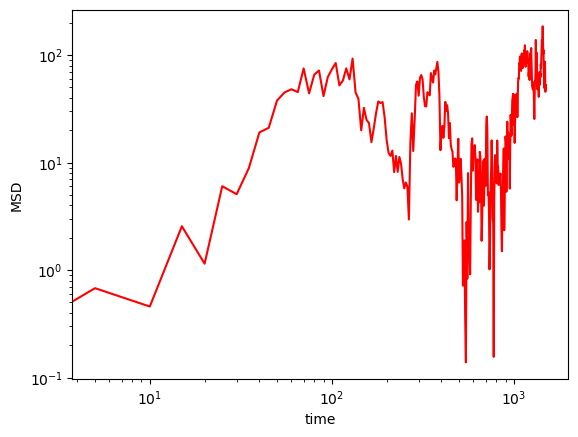

In [51]:
#dd = [[0],[0],[0],[0],[0],[0],[0],[0]]
dd = [[0]]
td = [0]

sel = 1
pick_i = 1

for z in range(0, 1):  
    for pick in range(pick_i, pick_i + 1):

        dd = [[0]]
        td = [0]
        
        for i in range(1,len(x_diffs_all[0][0])):
            if (j==0):
                if (z == 0):
                    td.append(i*5)
                    
                dd[z].append(x_diffs_all[0][pick][i]**2 + y_diffs_all[0][pick][i]**2)
            else:
                dd[z][i]+=x_diffs_all[0][pick][i]**2 + y_diffs_all[0][pick][i]**2
                
        for i in range(0,len(dd[z])):    
            dd[z][i] = dd[z][i]/1
    
        plt.loglog(td, dd[z][:], 'r');

#plt.plot(tdr, ddr, 'b');
# plt.xlim([0,5])
# plt.ylim([0,5])
plt.xlabel("time");
plt.ylabel("MSD");

In [50]:
print(x_diffs_all[0][1][:])


[0, np.float64(0.7572378216139402), np.float64(-0.24520710807172966), np.float64(-0.5636379127864686), np.float64(0.25126940620521726), np.float64(-0.015242452869739076), np.float64(2.2288068780478913), np.float64(2.8915151427709844), np.float64(4.369350434536448), np.float64(4.540340812358011), np.float64(6.069994593045952), np.float64(6.627590589417015), np.float64(6.797304093327959), np.float64(6.726764467515206), np.float64(8.66497646015824), np.float64(6.487494099867213), np.float64(7.26438796304602), np.float64(6.968113335059995), np.float64(4.626470129164912), np.float64(6.706313273634375), np.float64(6.00719196645468), np.float64(6.456638682969545), np.float64(4.314935218559484), np.float64(3.5309485483086673), np.float64(2.0235185648404173), np.float64(2.2916728444376164), np.float64(3.3499448627757284), np.float64(4.230643961364515), np.float64(4.117177557283097), np.float64(1.7684287984211056), np.float64(1.7087504830273337), np.float64(-0.8198513796933085), np.float64(-0.04